In [23]:
%matplotlib inline
import minecart

In [2]:
pdffile = open('../pdfs/EBLAmap1.pdf', 'rb')
doc = minecart.Document(pdffile)


page = doc.iter_pages()

In [3]:

for p in page:
    print 'page'
    for shape in p.shapes.iter_in_bbox((0, 0, 100, 200)):
        print shape.path, shape.fill.color.as_rgb()
    

    

page
[('m', 91.6445, 46.8184), ('l', 92.6365, 46.742399999999996), ('l', 93.8265, 46.8244), ('l', 94.2635, 46.944399999999995)]

AttributeError: 'NoneType' object has no attribute 'color'

In [4]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice

In [5]:
fp = open('../pdfs/EBLAmap1.pdf', 'rb')
parser = PDFParser(fp)
document = PDFDocument(parser)
if not document.is_extractable:
    raise PDFTextExtractionNotAllowed


rsrcmgr = PDFResourceManager()
device = PDFDevice(rsrcmgr)

interpreter = PDFPageInterpreter(rsrcmgr, device)

In [6]:
for page in PDFPage.create_pages(document):
    interpreter.process_page(page)

In [7]:
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator

In [8]:
laparams = LAParams()
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)
for page in PDFPage.create_pages(document):
    interpreter.process_page(page)
    
    layout = device.get_result()
    


In [10]:
layout.height

1215.0

In [13]:
from skimage import data, io, filters
import os

In [29]:
filename = '../out.jpg'
img = io.imread(filename, as_grey=False)

In [17]:
from skimage.filters import roberts, sobel, scharr, prewitt

In [20]:
#edge_roberts = roberts(img )

In [21]:
import matplotlib.pyplot as plt

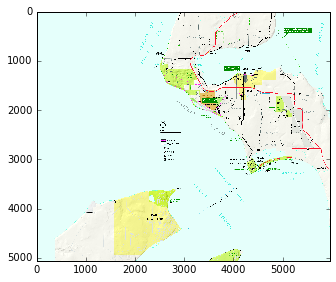

In [30]:
io.imshow(img)

In [39]:
from skimage import color, img_as_float
import numpy as np

In [63]:
fimg = img_as_float(img)
fimg.shape

(5063, 5956, 3)

In [64]:
filter_black = np.sum(fimg, axis=2)
fimg_bw = fimg.copy()
fimg_bw[(filter_black != 0)] = 1

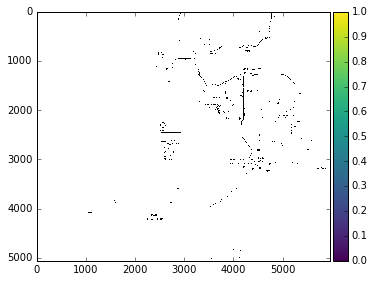

In [65]:
#fimg_bw.reshape(5063, 5956, 1)

io.imshow(fimg_bw)

In [88]:
fimg_bw.shape

(5063, 5956, 3)

In [190]:
import numpy as np

In [338]:

class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    def width(self):
        return self.x2 - self.x1
    
    def height(self):
        return self.y2 - self.y1
    
    def x_extent(self):
        return self.x1 + self.width()

    def y_extent(self):
        return self.y1 + self.height()
    
    def extract(self, img):
        return img[(b.y1 - 1):b.y_extent(), (b.x1 - 1):b.x_extent(), :]

    
    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1
    
    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))
    
    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)

    
def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

        
def remove_overlaps(bboxes):
    '''
    Return a set of BBoxes which contain the given BBoxes.
    When two BBoxes overlap, replace both with the minimal BBox that contains both.
    '''
    # list upper left and lower right corners of the Bboxes
    corners = []

    # list upper left corners of the Bboxes
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)        

    # Use a KDTree so we can find corners that are nearby efficiently.
    tree = spatial.KDTree(corners)
    new_corners = []
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(
            corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both bboxes.
                # Since we mutate the bbox, all references to this bbox in
                # bbox_map are updated simultaneously.
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1) 
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2) 
    return set(bbox_map.values())

def remove_dups(bboxes):
    clean_set = []
    for bbox in bboxes:
        if bbox not in clean_set:
            clean_set.append(bbox)
    return clean_set

In [339]:
fimg_bw_one = fimg_bw[:,:,1]
fimg_bw_one_invert = 1 - fimg_bw_one
labels, numobjects = ndimage.label(fimg_bw_one_invert)
slices = ndimage.find_objects(labels)

bboxes = (slice_to_bbox(slices))
#len(bboxes)
bboxes = remove_dups(bboxes)

In [340]:
print(len(bboxes))

2390


In [341]:
bbox_list = []
for bbox in bboxes:
    bbox_list.append(bbox)
    

In [342]:
bboxes_filter = [bbox for bbox in bbox_list if (bbox.width() > 30) and (bbox.width() < 50) and (bbox.height() > 30) and (bbox.height() < 50)]
len(bboxes_filter)

36

2570
2612


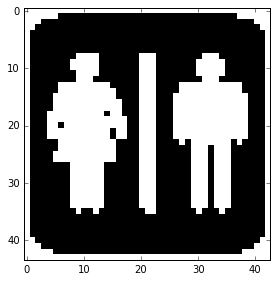

In [343]:
b = bboxes_filter[15]
print(b.x1)
print(b.x2)
#ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
ddd = b.extract(fimg_bw)
#print(b.width())
io.imshow(ddd)

In [352]:
sum(np.sum(ddd[:,:,1], axis=1))

739.0

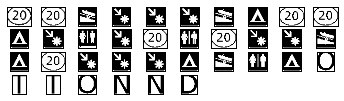

In [334]:

fig = plt.figure()
i = 1
for b in bboxes_filter:
    ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(10,10,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(ddd) 

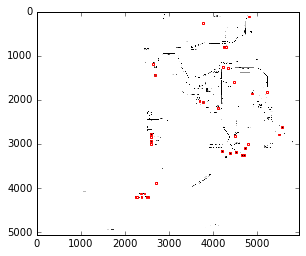

In [353]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(fimg_bw)    
for bbox in bboxes_filter:
    xwidth = bbox.x2 - bbox.x1
    ywidth = bbox.y2 - bbox.y1
    p = patches.Rectangle((bbox.x1, bbox.y1), bbox.width(), bbox.height(),
                          fc = 'none', ec = 'red')
    ax.add_patch(p)

In [67]:
window_size = 40

rows = fimg_bw.shape[0]
cols = fimg_bw.shape[1]

In [93]:
#x = np.sum(np.sum(fimg_bw[0:5, 1:3, :], axis=2))
#x

30.0

In [128]:
(40 * 40) * .8
((40 * 40) * .2 * 3)
#320 * 3

960.0

In [135]:
squares = []
sums = []
for i in xrange(0, rows, 5):
    for j in xrange(0, cols, 5):
        if (i+window_size < rows) & (j+window_size < cols):
            window_sum = np.sum(np.sum(fimg_bw[i:(i+window_size), j:(j+window_size), :], axis=2))
            if window_sum < 960.0:
                squares.append((i,j))

#squares

In [136]:
min(sums)

ValueError: min() arg is an empty sequence

In [137]:
len(squares)

0

In [134]:
squares[0]

(0, 5950)

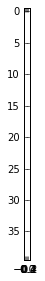

In [133]:
square = squares[1]
s_img = fimg_bw[square[0]:(square[0]+window_size), square[1]:(square[1]+window_size), :]
io.imshow(s_img)

In [170]:
from skimage import measure

contours = measure.find_contours(fimg_bw_one, 0.01, fully_connected='low')

len(contours)

2426

In [174]:
contours[0][:, 0]


array([ 966.  ,  965.01,  965.  , ...,  966.  ,  966.01,  966.  ])

In [175]:
import numpy as np
import scipy.ndimage as ndimage
import scipy.spatial as spatial
import scipy.misc as misc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1
    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))
    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)

def find_paws(data, smooth_radius = 5, threshold = 0.0001):
    # http://stackoverflow.com/questions/4087919/how-can-i-improve-my-paw-detection
    """Detects and isolates contiguous regions in the input array"""
    # Blur the input data a bit so the paws have a continous footprint 
    #data = ndimage.uniform_filter(data, smooth_radius)
    # Threshold the blurred data (this needs to be a bit > 0 due to the blur)
    thresh = data > threshold
    # Fill any interior holes in the paws to get cleaner regions...
    filled = ndimage.morphology.binary_fill_holes(thresh)
    # Label each contiguous paw
    coded_paws, num_paws = ndimage.label(filled)
    # Isolate the extent of each paw
    # find_objects returns a list of 2-tuples: (slice(...), slice(...))
    # which represents a rectangular box around the object
    data_slices = ndimage.find_objects(coded_paws)
    return data_slices

def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

def remove_overlaps(bboxes):
    '''
    Return a set of BBoxes which contain the given BBoxes.
    When two BBoxes overlap, replace both with the minimal BBox that contains both.
    '''
    # list upper left and lower right corners of the Bboxes
    corners = []

    # list upper left corners of the Bboxes
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)        

    # Use a KDTree so we can find corners that are nearby efficiently.
    tree = spatial.KDTree(corners)
    new_corners = []
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(
            corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both bboxes.
                # Since we mutate the bbox, all references to this bbox in
                # bbox_map are updated simultaneously.
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1) 
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2) 
    return set(bbox_map.values())

# if __name__ == '__main__':
#     fig = plt.figure()
#     ax = fig.add_subplot(111)

#     data = misc.imread('image.png')
#     im = ax.imshow(data)    
#     data_slices = find_paws(255-data, smooth_radius = 20, threshold = 22)

#     bboxes = remove_overlaps(slice_to_bbox(data_slices))
#     for bbox in bboxes:
#         xwidth = bbox.x2 - bbox.x1
#         ywidth = bbox.y2 - bbox.y1
#         p = patches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth,
#                               fc = 'none', ec = 'red')
#         ax.add_patch(p)

#     plt.show()

In [180]:
filter_black = np.sum(img, axis=2)
img_bw = img.copy()
img_bw[(filter_black != 0)] = 255

In [186]:
data_slices = find_paws(255-img_bw, smooth_radius = 5)
bboxes = remove_overlaps(slice_to_bbox(data_slices))

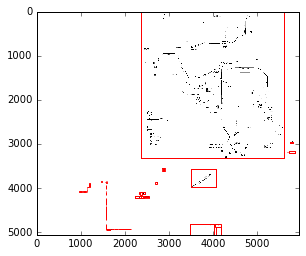

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(img_bw)    
for bbox in bboxes:
    xwidth = bbox.x2 - bbox.x1
    ywidth = bbox.y2 - bbox.y1
    p = patches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth,
                          fc = 'none', ec = 'red')
    ax.add_patch(p)

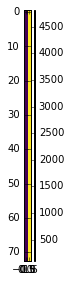

In [158]:
io.imshow(contours[20])

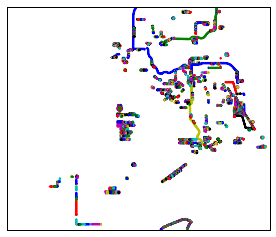

In [166]:
fig, ax = plt.subplots()
ax.imshow(fimg_bw)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('temp.png')
plt.show()

In [66]:
io.imsave("bw_tmp.png", fimg_bw)

/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: bw_tmp.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [27]:
from skimage import feature

edges2 = feature.canny(img, sigma=3)


/Users/vlandham/code/python/miniconda2/envs/pdf/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


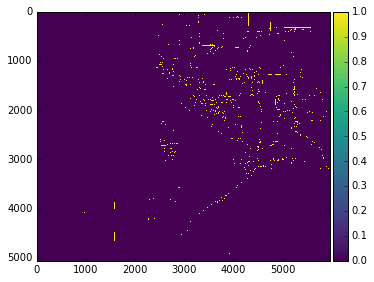

In [28]:
io.imshow(edges2)